Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**Importing Skin Cancer Data**

**To do: Take necessary actions to read the data**

Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img

In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### **Create a dataset**

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            batch_size=batch_size,
            image_size=(img_height, img_width),
            seed=123,
            validation_split=0.2,
            subset='training',
            )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            batch_size=batch_size,
            image_size=(img_height, img_width),
            seed=123,
            validation_split=0.2,
            subset='validation',
            )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**Visualize the data**

Found 2239 files belonging to 9 classes.


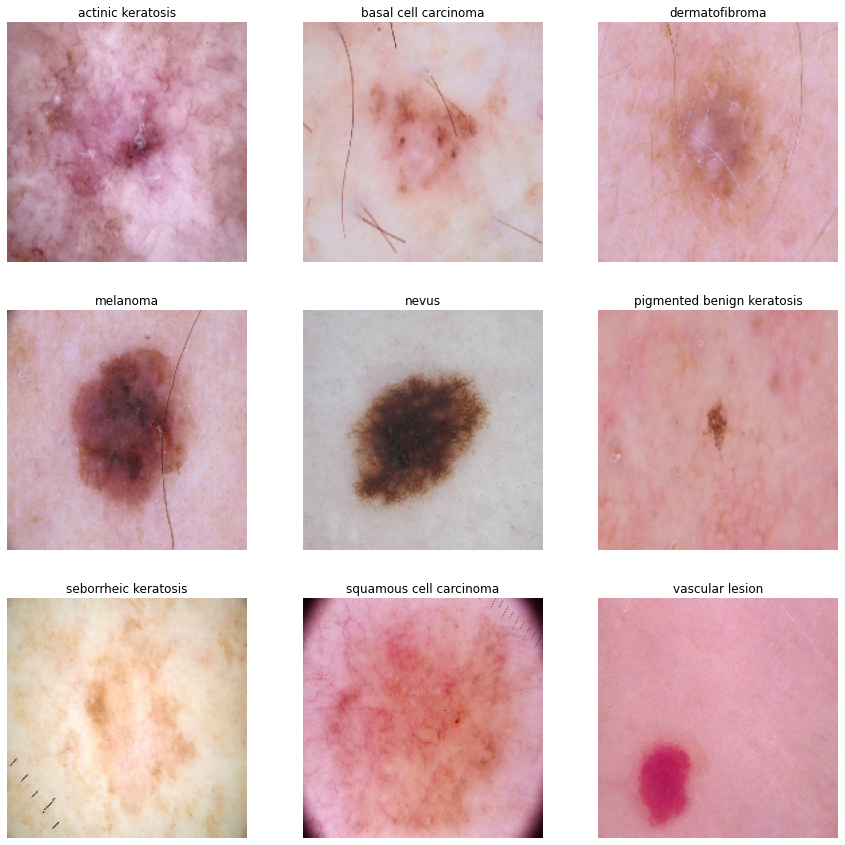

In [10]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [11]:
#Visualize distribution of classes in the training dataset.

def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,nevus,357
1,squamous cell carcinoma,181
2,vascular lesion,139
3,actinic keratosis,114
4,seborrheic keratosis,77
5,melanoma,438
6,dermatofibroma,95
7,basal cell carcinoma,376
8,pigmented benign keratosis,462


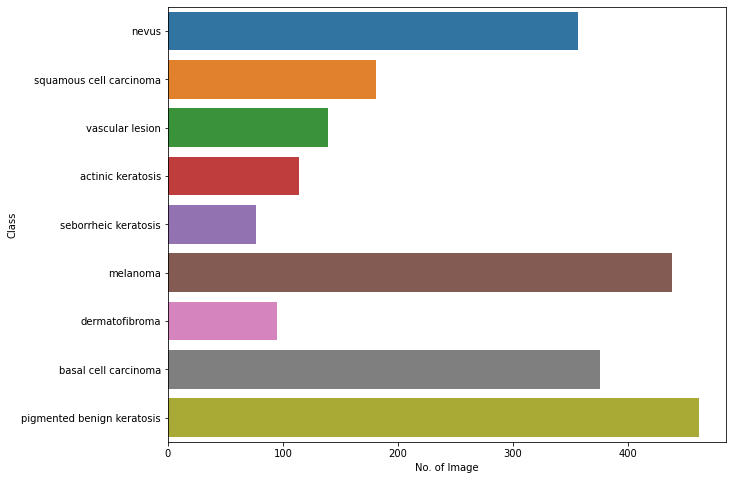

In [12]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Create the model 1**

Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [14]:
### Your code goes here

num_class = 9
model = tf.keras.Sequential([
    layers.Rescaling(scale = 1./255, input_shape = (180,180,3)),
    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),    
    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Conv2D(128,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_class, activation='softmax')
])

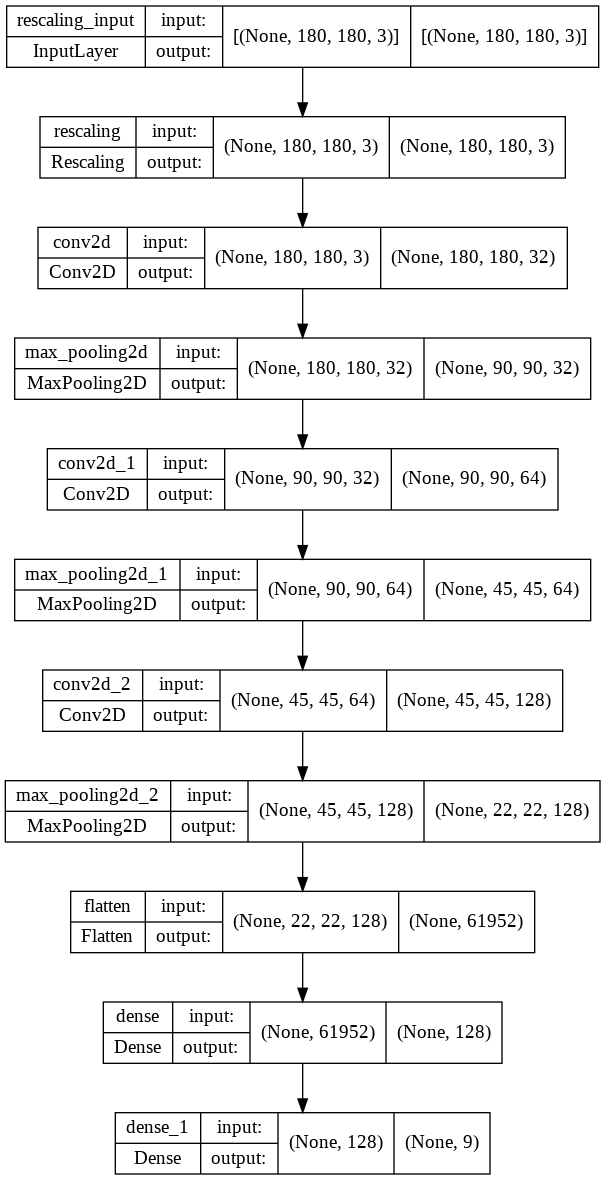

In [15]:
# vizualizing the model 
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Compile the model 1**

In [16]:
#choosing an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

**Train the model 1**

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 429s 3s/step - loss: 2.0847 - accuracy: 0.2081 - val_loss: 1.9180 - val_accuracy: 0.3490
Epoch 2/20
56/56 [==============================] - 131s 2s/step - loss: 1.7874 - accuracy: 0.3449 - val_loss: 1.6003 - val_accuracy: 0.4340
Epoch 3/20
56/56 [==============================] - 129s 2s/step - loss: 1.4962 - accuracy: 0.4810 - val_loss: 1.3792 - val_accuracy: 0.5391
Epoch 4/20
56/56 [==============================] - 129s 2s/step - loss: 1.4348 - accuracy: 0.4944 - val_loss: 1.4977 - val_accuracy: 0.5011
Epoch 5/20
56/56 [==============================] - 129s 2s/step - loss: 1.2862 - accuracy: 0.5564 - val_loss: 1.3524 - val_accuracy: 0.5391
Epoch 6/20
56/56 [==============================] - 129s 2s/step - loss: 1.3320 - accuracy: 0.5195 - val_loss: 1.3383 - val_accuracy: 0.5257
Epoch 7/20
56/56 [==============================] - 129s 2s/step - loss: 1.2076 - accuracy: 0.5826 - val_loss: 1.3867 - val_accuracy: 0.5548
Epoch 8/20
56/56 [======

**Visualizing training results**

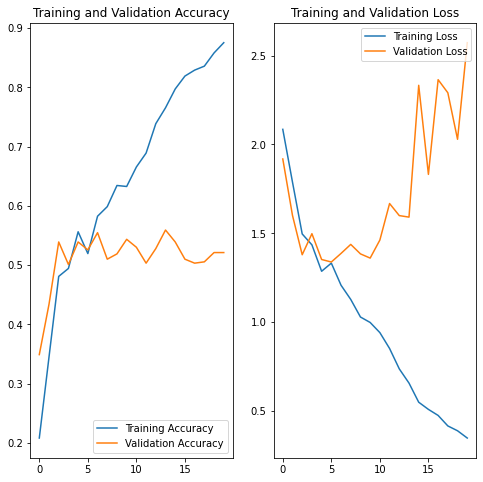

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Conclusion from Model-1**
From the model 1 we can clearly see that the model is overfited.

The difference between trian and validation Accuracy of the Mode is more than 30%.

As we have less train data we can try models with Data augmentation

**Create the model-2: Manual augmentation**

Chose an appropriate data augmentation strategy to resolve underfitting/overfitting 


In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

with tf.device('/gpu:0'):
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
    ])

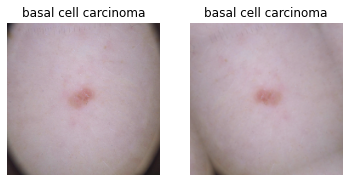

In [21]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

for image, label in train_ds.take(1):
        ax = plt.subplot(1, 2, 1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')
        
        augmented = data_augmentation(image)
        ax = plt.subplot(1, 2, 2)
        plt.imshow(augmented[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

**Create the model 2**

In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings


num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.30),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.20),
  layers.Dense(num_classes,activation='softmax')
])

**Compiling the model-2**

In [23]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

**Training the model-2**

In [24]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 138s 2s/step - loss: 2.0518 - accuracy: 0.2070 - val_loss: 1.8635 - val_accuracy: 0.2707
Epoch 2/20
56/56 [==============================] - 135s 2s/step - loss: 1.7131 - accuracy: 0.3638 - val_loss: 1.6132 - val_accuracy: 0.4564
Epoch 3/20
56/56 [==============================] - 134s 2s/step - loss: 1.5349 - accuracy: 0.4654 - val_loss: 1.4622 - val_accuracy: 0.4653
Epoch 4/20
56/56 [==============================] - 135s 2s/step - loss: 1.4630 - accuracy: 0.4771 - val_loss: 1.4175 - val_accuracy: 0.5123
Epoch 5/20
56/56 [==============================] - 135s 2s/step - loss: 1.4425 - accuracy: 0.5033 - val_loss: 1.4829 - val_accuracy: 0.4944
Epoch 6/20
56/56 [==============================] - 135s 2s/step - loss: 1.4216 - accuracy: 0.5022 - val_loss: 1.3750 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 134s 2s/step - loss: 1.3514 - accuracy: 0.5268 - val_loss: 1.3640 - val_accuracy: 0.5213
Epoch 8/20
56

**Visualizing the results**

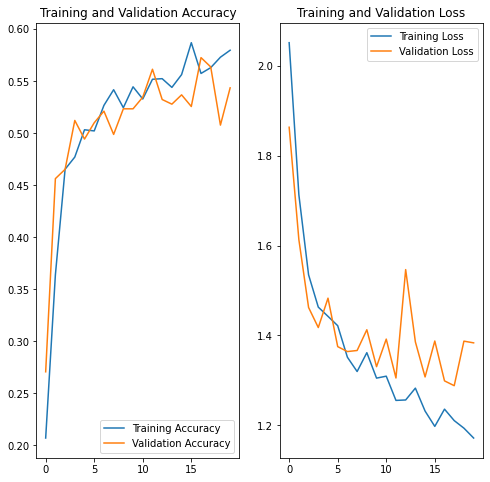

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Conclusions from Model-2**

The application of data augmentation and dropout layer has clearly reduced the overfitting.

We can see difference between train and validation accuracy is reduced and overall effeciency has increased.

**Create the model-3: Automatic data augmentation**

This model is based on Automatic data augmentation.

Checking data in each class

<BarContainer object of 9 artists>

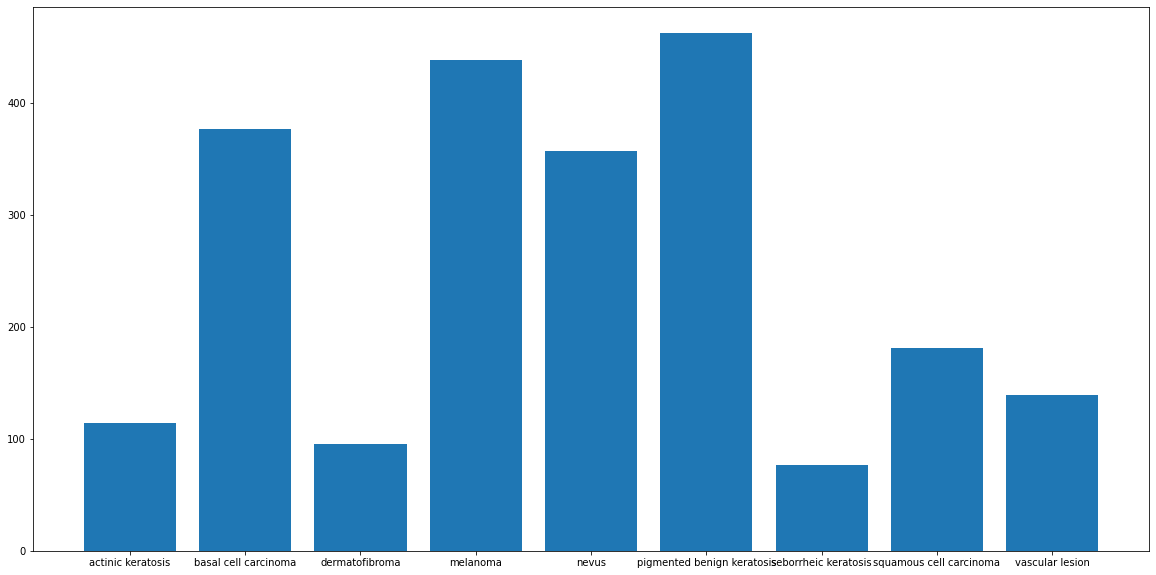

In [26]:
## Your code goes here.
class_count=[]
for i in class_names:
    class_count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(20,10))
plt.bar(class_names,class_count)

We can see there is class imbalance. So we need to balance the data.

Using Automatic Augmentor.

In [27]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
path_to_training_dataset='/content/gdrive/MyDrive/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6592B47090>: 100%|██████████| 500/500 [00:26<00:00, 18.99 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6595886610>: 100%|██████████| 500/500 [00:25<00:00, 19.57 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6592C142D0>: 100%|██████████| 500/500 [00:26<00:00, 18.97 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7F6592B7BC10>: 100%|██████████| 500/500 [01:55<00:00,  4.34 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7F6592B05910>: 100%|██████████| 500/500 [01:37<00:00,  5.15 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F65957B0C90>: 100%|██████████| 500/500 [00:24<00:00, 20.41 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F6592BBAD10>: 100%|██████████| 500/500 [00:52<00:00,  9.52 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F65936E5BD0>: 100%|██████████| 500/500 [00:23<00:00, 21.66 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F66153417D0>: 100%|██████████| 500/500 [00:27<00:00, 17.87 Samples/s]


In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Distribution of augmented data after addition of new images to the original training data.**

In [30]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [32]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [34]:
df2['Label'].value_counts()

nevus                         500
squamous cell carcinoma       500
vascular lesion               500
actinic keratosis             500
seborrheic keratosis          500
melanoma                      500
dermatofibroma                500
basal cell carcinoma          500
pigmented benign keratosis    500
Name: Label, dtype: int64

**Train the model on the data created using Augmentor**

In [35]:
batch_size = 32
img_height = 180
img_width = 180

**Create a training dataset**

In [36]:
data_dir_train="/content/gdrive/MyDrive/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


**Create a validation dataset**

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


**Create the model-3**

In [38]:
## your code goes here
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)      

**Compile your model-3**

In [39]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Train your model-3**

In [40]:
epochs = 20
## Your code goes here, use 20 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 391s 2s/step - loss: 1.7783 - accuracy: 0.3259 - val_loss: 1.5093 - val_accuracy: 0.4425
Epoch 2/20
169/169 [==============================] - 387s 2s/step - loss: 1.4530 - accuracy: 0.4466 - val_loss: 1.3785 - val_accuracy: 0.4744
Epoch 3/20
169/169 [==============================] - 386s 2s/step - loss: 1.3091 - accuracy: 0.5083 - val_loss: 1.2482 - val_accuracy: 0.5219
Epoch 4/20
169/169 [==============================] - 388s 2s/step - loss: 1.1692 - accuracy: 0.5612 - val_loss: 1.1226 - val_accuracy: 0.5768
Epoch 5/20
169/169 [==============================] - 387s 2s/step - loss: 1.0232 - accuracy: 0.6272 - val_loss: 1.0618 - val_accuracy: 0.5917
Epoch 6/20
169/169 [==============================] - 388s 2s/step - loss: 0.9141 - accuracy: 0.6626 - val_loss: 0.9351 - val_accuracy: 0.6548
Epoch 7/20
169/169 [==============================] - 382s 2s/step - loss: 0.8207 - accuracy: 0.7036 - val_loss: 0.7962 - val_accuracy: 0.7030

**Visualize the model results**

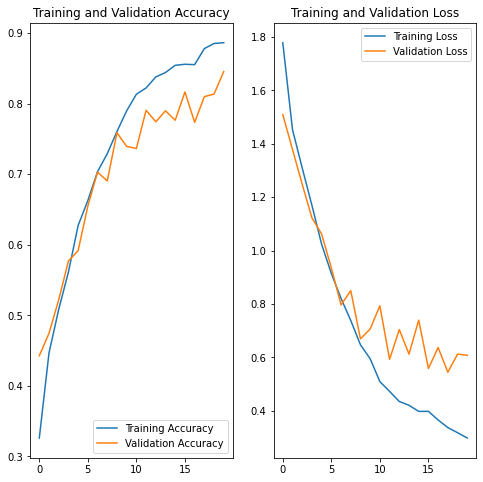

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Conclusion from model-3**

Doing class rebalance helped us to get rid of the overfitting. Hence data augmentation helps to reduce the overfitting.  

The performance of the model is similar on both training and validation data Both training and validation accuracy have increased.

**The final model gives Train accuracy of 0.8865 and Validation accuracy of 0.8456**